## Testing the backward method by comparing to Finite Difference results

In [1]:
from transform import simplex_ft_bw_gpu, simplex_ft_gpu
import numpy as np
import matplotlib.pyplot as plt

# Vertex matrix
V = np.array([[0.2,0.2],
              [0.8,0.5],
              [0.8,0.8],
              [0.6,0.8]])
V = V+1e-4*np.random.rand(*V.shape) # break the symmetry with small random noise
# Element matrix
E = np.array([[0,1],
              [1,2],
              [2,3],
              [3,0]])
# Density matrix (Unit Density)
D = np.ones((E.shape[0], 1))
# Sensitivity on each frequency mode
dF = np.ones((256, 128, 1), dtype=np.complex_) # unit sensitivity

### Visualize the shape

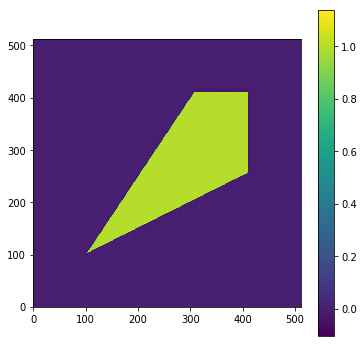

In [2]:
Freq = simplex_ft_gpu(V, E, D, (512,512),(1,1),2)
%matplotlib inline

plt.figure(figsize=(6,6))
plt.imshow(np.fft.irfft2(np.squeeze(Freq), (512,512)).T, origin='lower')
plt.colorbar()
plt.show()

### The additional row in adjoint solution is for the "ghost" vertex, which is close to zero.

In [3]:
# Finite difference approximation
delta = 1e-6
dV_fd_all = np.zeros(list(V.shape)+list(dF.shape), dtype=np.complex_)
for i in range(V.shape[0]):
    for j in range(V.shape[1]):
        V_p = V.copy()
        V_m = V.copy()
        V_p[i, j] += delta
        V_m[i, j] -= delta
        Freq_p = simplex_ft_gpu(V_p, E, D, (256,256),(1,1),2, mode='density')
        Freq_m = simplex_ft_gpu(V_m, E, D, (256,256),(1,1),2, mode='density')
        dV_fd_all[i,j] = (Freq_p - Freq_m) / delta / 2
dV_fd = np.sum(dV_fd_all, (2,3,4))
        
# Analytical Adjoint solution
dV = simplex_ft_bw_gpu(dF, V, E, D, (256, 256), (1,1), 2, mode='density')

# Print and compare
print("Finite Difference Approximation: \n", dV_fd, "\n")
print("Analytical Adjoint: \n", dV, "\n")

# Relative error
nvert = V.shape[0]
rdiff = np.mean(np.absolute((dV_fd - dV[:nvert])/dV[:nvert]))
print("Relative error (%): \n", rdiff*100)

Finite Difference Approximation: 
 [[-1.41944850e+02  +22.56441196j  2.23308548e+02  -85.13461495j]
 [-4.62487745e+03+1338.47779989j -1.16721829e+00  +31.55004744j]
 [-5.73537120e+03 -244.46633319j -1.58926353e+02 -107.6128714j ]
 [ 2.23398351e+01 -102.45691998j -6.15432396e+01  +69.44118075j]] 

Analytical Adjoint: 
 [[-1.41945123e+02+2.25647662e+01j  2.23306300e+02-8.51344349e+01j]
 [-4.62487160e+03+1.33847856e+03j -1.16554535e+00+3.15493068e+01j]
 [-5.73537190e+03-2.44466395e+02j -1.58922257e+02-1.07613567e+02j]
 [ 2.23523675e+01-1.02456578e+02j -6.15569748e+01+6.94397872e+01j]
 [ 2.05331054e-03+3.80212441e-07j -1.79164088e-03-3.53902578e-07j]] 

Relative error (%): 
 0.004522777465460862
